In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [2]:
# Import the two data sets
ny = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xlsx',
                  header=4, skipfooter=3)

ca = pd.read_excel('table_8_offenses_known_to_law_enforcement_california_by_city_2013.xls', 
                  header=4, skipfooter=2)


In [3]:
# Clean up column names to be worked with
def fix_column_names(data):
    data.columns = data.columns.str.replace('\n', '_')
    data.columns = data.columns.str.replace('(', '')
    data.columns = data.columns.str.replace(')', '')
    data.columns = data.columns.str.replace('-', '')
    data.columns = data.columns.str.replace(' ', '')
    data.columns = data.columns.str.lower()
    
    return data.columns

In [4]:
# Clean up the column names
ca.columns = fix_column_names(ca)
ny.columns = fix_column_names(ny)

print(ca.columns)

Index(['city', 'population', 'violent_crime',
       'murderand_nonnegligent_manslaughter', 'rape_revised_definition1',
       'rape_legacy_definition2', 'robbery', 'aggravated_assault',
       'property_crime', 'burglary', 'larceny_theft', 'motor_vehicle_theft',
       'arson'],
      dtype='object')


In [5]:
ny[ny['city']=='New York']

,city,population,violent_crime,murderand_nonnegligent_manslaughter,rape_revised_definition1,rape_legacy_definition2,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson3
216,New York,8396126,52384,335,NaN,1112,19170,31767,141971,16606,117931,7434,NaN


In [6]:
# Remove NY City because it is an outlier (from exploratory analysis in previous exercise)
ny.drop(index=216, inplace=True)

In [7]:
# Try removing a LA - also a large city/outlier
ca[ca['population'] > 1000000]
ca.drop(index=234, inplace=True)

In [8]:
columns = list(ny.columns)#.remove('property_crime')
columns.remove('property_crime')
columns.remove('rape_revised_definition1')
columns.remove('city')
formula = "+".join(columns)

linear_formula = "property_crime~" + formula

lm = smf.ols(formula=linear_formula, data=ny).fit()

In [9]:
print(linear_formula)

property_crime~population+violent_crime+murderand_nonnegligent_manslaughter+rape_legacy_definition2+robbery+aggravated_assault+burglary+larceny_theft+motor_vehicle_theft+arson3


In [10]:
lm.params

Intercept                             -3.694822e-13
population                             2.862294e-17
violent_crime                         -1.421085e-14
murderand_nonnegligent_manslaughter   -1.136868e-13
rape_legacy_definition2                3.552714e-14
robbery                                1.776357e-14
aggravated_assault                     8.881784e-15
burglary                               1.000000e+00
larceny_theft                          1.000000e+00
motor_vehicle_theft                    1.000000e+00
arson3                                -1.154632e-14
dtype: float64

In [11]:
lm.pvalues

Intercept                              0.002420
population                             0.028459
violent_crime                          0.629634
murderand_nonnegligent_manslaughter    0.358533
rape_legacy_definition2                0.508479
robbery                                0.596265
aggravated_assault                     0.751572
burglary                               0.000000
larceny_theft                          0.000000
motor_vehicle_theft                    0.000000
arson3                                 0.807697
dtype: float64

In [12]:
lm.rsquared

1.0

This is suspicious - further reading shows that the definition of property crime is burglary + larceny + motor_vehicle_theft + arson3.  Remove burglary, larceny_theft, motor_vehicle_theft and arson3 from the model.

Also, violent crime is murder and nonnegligent manslaughter, rape, robbery, and aggravated assault.

In [13]:
revised_columns = ['population', 'murderand_nonnegligent_manslaughter', 'rape_legacy_definition2', 
                   'robbery', 'aggravated_assault']

formula = "+".join(revised_columns)

linear_formula = "property_crime~" + formula

lm = smf.ols(formula=linear_formula, data=ny).fit()

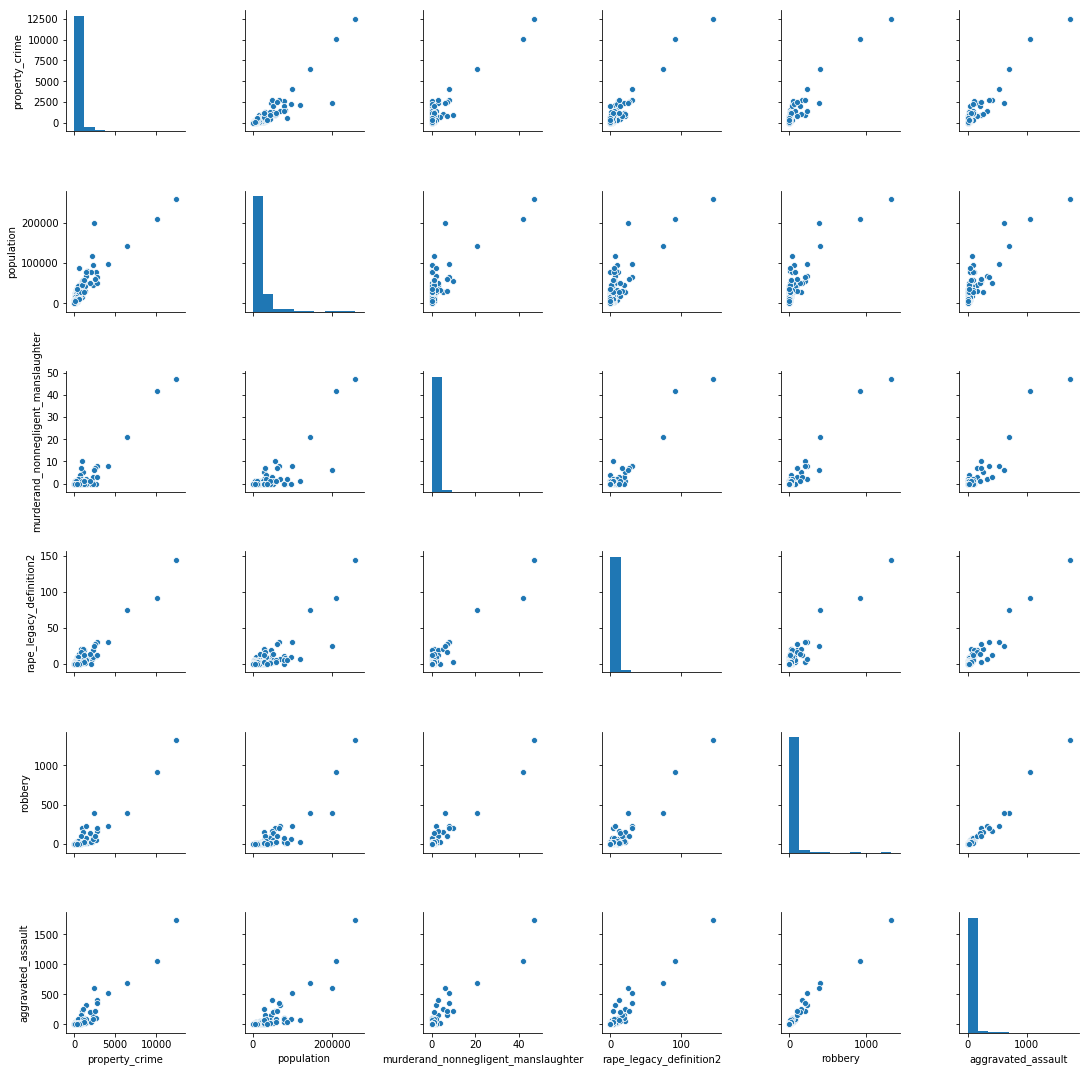

In [14]:
sns.pairplot(ny[['property_crime'] + revised_columns])

In [15]:
lm.params

Intercept                               9.480260
population                              0.013521
murderand_nonnegligent_manslaughter    56.680944
rape_legacy_definition2                45.025137
robbery                                -0.950320
aggravated_assault                      0.753546
dtype: float64

In [16]:
lm.pvalues

Intercept                              5.482046e-01
population                             1.502831e-43
murderand_nonnegligent_manslaughter    1.952370e-04
rape_legacy_definition2                7.081721e-19
robbery                                3.287495e-01
aggravated_assault                     2.514134e-01
dtype: float64

In [17]:
lm.rsquared

0.9509826192386062

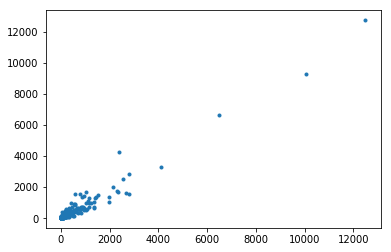

In [18]:
y = ny['property_crime']
y_pred = lm.fittedvalues
plt.plot(y, y_pred, linestyle='none', marker='.')
plt.show()

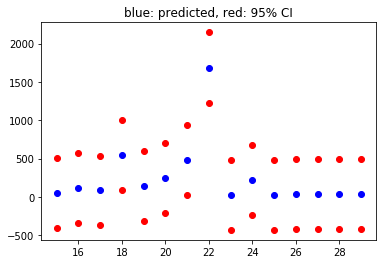

In [19]:
# Use wls_prediction_std to build confidence intervals

prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()
plt.plot(iv_u[15:30], 'o', color='r')
plt.plot(iv_l[15:30], 'o', color='r')
plt.plot(lm.fittedvalues[15:30], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()

Text(0.5,0,'Residuals')

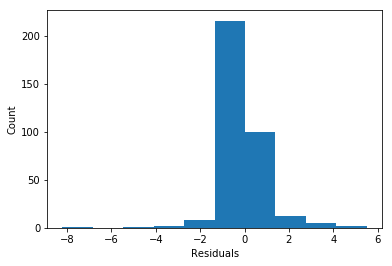

In [20]:
plt.hist(lm.resid_pearson)
plt.ylabel('Count')
plt.xlabel('Residuals')

In [21]:
# Try another model (the example one from a few units earlier)
ny['population_square'] = ny['population']**2
ca['population_square'] = ca['population']**2

In [22]:
ny['murder'] = np.where(ny['murderand_nonnegligent_manslaughter'] > 0, 1, 0)
ca['murder'] = np.where(ca['murderand_nonnegligent_manslaughter'] > 0, 1, 0)

In [23]:
ny['robbery2'] = np.where(ny['robbery'] > 0, 1, 0)
ca['robbery2'] = np.where(ca['robbery'] > 0, 1, 0)

In [24]:
revise2 = ['population', 'population_square', 'murder', 'robbery2']

formula = "+".join(revise2)

linear_formula = "property_crime~" + formula

lm2 = smf.ols(formula=linear_formula, data=ny).fit()

In [25]:
lm2.params

Intercept           -1.681587e+01
population           1.295109e-02
population_square    1.149205e-07
murder               1.950387e+02
robbery2             9.282058e+01
dtype: float64

In [26]:
lm2.pvalues

Intercept            6.408973e-01
population           5.765236e-09
population_square    1.727610e-24
murder               1.137283e-02
robbery2             7.204162e-02
dtype: float64

In [27]:
lm2.rsquared

0.8444937611173492

This is not as good of a model

In [28]:
y_pred = lm2.fittedvalues

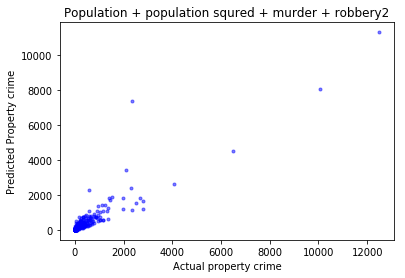

In [29]:
plt.plot(y, y_pred, linestyle='none', marker='.', alpha=.5, color='blue')
plt.xlabel('Actual property crime')
plt.ylabel('Predicted Property crime')
plt.title('Population + population squred + murder + robbery2')
plt.show()

Text(0.5,0,'Residuals')

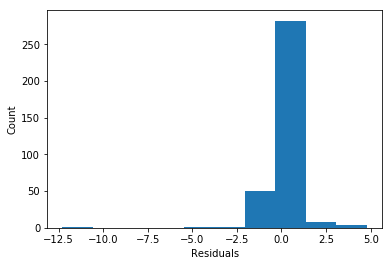

In [30]:
plt.hist(lm2.resid_pearson)
plt.ylabel('Count')
plt.xlabel('Residuals')

In [31]:
# Since violent crime is equal to the other parameters added, try just with violent crime
revised3 = ['population', 'violent_crime']

formula = "+".join(revised3)

linear_formula = "property_crime~" + formula

lm3 = smf.ols(formula=linear_formula, data=ny).fit()

In [32]:
lm3.params

Intercept        33.162437
population        0.012727
violent_crime     2.919475
dtype: float64

In [33]:
lm3.pvalues

Intercept        8.222107e-02
population       1.141345e-30
violent_crime    2.439765e-81
dtype: float64

In [34]:
lm3.rsquared

0.9264365606475871

Still not as good as previous

Text(0.5,0,'Residuals')

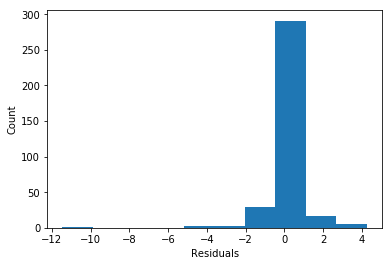

In [35]:
plt.hist(lm3.resid_pearson)
plt.ylabel('Count')
plt.xlabel('Residuals')

In [36]:
revised4 = ['murderand_nonnegligent_manslaughter', 'population',
                   'robbery', 'aggravated_assault']

formula = "+".join(revised4)

linear_formula = "property_crime~" + formula

lm4 = smf.ols(formula=linear_formula, data=ny).fit()

In [37]:
lm4.params

Intercept                               21.449554
murderand_nonnegligent_manslaughter    131.155823
population                               0.014081
robbery                                 -3.445322
aggravated_assault                       4.051620
dtype: float64

In [38]:
lm4.rsquared

0.9382299441204732

In [39]:
lm4.pvalues

Intercept                              2.243841e-01
murderand_nonnegligent_manslaughter    5.789145e-18
population                             3.300329e-39
robbery                                1.114563e-03
aggravated_assault                     2.568335e-10
dtype: float64

## Check Model 4 with CA

In [40]:
# create X and y
X = ny[revised4]
y = ny.property_crime

# instantiate
lm4 = LinearRegression()
# fit
model = lm4.fit(X, y)

# print coefficients
print(list(zip(revised4, lm4.coef_)))


[('murderand_nonnegligent_manslaughter', 131.1558233267861), ('population', 0.014080765720039017), ('robbery', -3.4453222579989022), ('aggravated_assault', 4.0516202389284395)]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [41]:
y_pred_ca = model.predict(ca[revised4])
model.score(ca[revised4], ca['property_crime'].values.reshape(-1,1))

0.7468166049838549

## Check model 3 with CA

In [42]:
# create X and y
X = ny[revised3]
y = ny.property_crime

# instantiate
lm3 = LinearRegression()
# fit
model = lm3.fit(X, y)

# print coefficients
print(list(zip(revised3, lm3.coef_)))

[('population', 0.01272656979870404), ('violent_crime', 2.919475495463388)]


In [43]:
y_pred_ca = model.predict(ca[revised3])
model.score(ca[revised3], ca['property_crime'].values.reshape(-1,1))

0.9142640572295261

## Check Model 2 with CA

In [44]:
# create X and y
X = ny[revise2]
y = ny.property_crime

# instantiate
lm2 = LinearRegression()
# fit
model = lm2.fit(X, y)

# print coefficients
print(list(zip(revise2, lm2.coef_)))

[('population', 0.012951087147310216), ('population_square', 1.1492052761697948e-07), ('murder', 195.03866563805332), ('robbery2', 92.82058454517302)]


In [45]:
y_pred_ca = model.predict(ca[revise2])
model.score(ca[revise2], ca['property_crime'].values.reshape(-1,1))

-6.889091709019881

## Check original model with CA

In [46]:
# create X and y
X = ny[revised_columns]
y = ny.property_crime

# instantiate
lm = LinearRegression()
# fit
model = lm.fit(X, y)

# print coefficients
print(list(zip(revised_columns, lm.coef_)))

[('population', 0.013521112045402671), ('murderand_nonnegligent_manslaughter', 56.68094393568588), ('rape_legacy_definition2', 45.025137473899136), ('robbery', -0.950319956664686), ('aggravated_assault', 0.7535459020534949)]


In [47]:
y_pred_ca = model.predict(ca[revised_columns])
model.score(ca[revised_columns], ca['property_crime'].values.reshape(-1,1))

0.8001048555509326

Text(0,0.5,'Predicted Property Crime')

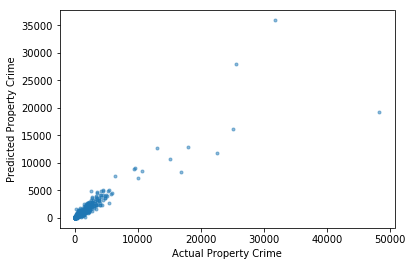

In [48]:
plt.plot(ca['property_crime'], y_pred_ca, linestyle='none', marker='.', alpha=.5)
plt.xlabel('Actual Property Crime')
plt.ylabel('Predicted Property Crime')

In [49]:
ca['y_pred_ca'] = y_pred_ca

In [50]:
ca[ca['y_pred_ca'] > 20000]

,city,population,violent_crime,murderand_nonnegligent_manslaughter,rape_revised_definition1,rape_legacy_definition2,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson,population_square,murder,robbery2,y_pred_ca
353,San Diego,1349306,5303,39,NaN,316,1456,3492,31728,6355,19230,6143,178,1820626681636,1,1,35939.814558
360,San Jose,992143,3215,38,NaN,270,1095,1812,25510,5173,12411,7926,133,984347732449,1,1,28059.844737


It is predicting a huge amount of crime for cities with a high population

In [51]:
revise4 = ['population', 'murder', 'robbery2']
# create X and y
X = ny[revise4]
y = ny.property_crime

# instantiate
lm2 = LinearRegression()
# fit
model = lm2.fit(X, y)

# print coefficients
list(zip(revise4, lm2.coef_))

[('population', 0.03438607640518721),
 ('murder', 14.34737750509695),
 ('robbery2', -94.25213338174214)]

In [52]:
model.score(ca[revise4], ca['property_crime'])

0.8154661872672487

In [53]:
y_pred_ca = model.predict(ca[revise4])

Text(0,0.5,'Predicted Property Crime')

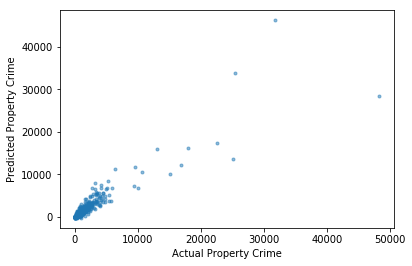

In [54]:
plt.plot(ca['property_crime'], y_pred_ca, linestyle='none', marker='.', alpha=.5)
plt.xlabel('Actual Property Crime')
plt.ylabel('Predicted Property Crime')

## Best model for CA and NY
Selecting model 3 using just the population and violent crime seems to be the best fit for CA and NY data

# Check on another holdout data set

In [55]:
ma = pd.read_excel('table_8_offenses_known_to_law_enforcement_massachusetts_by_city_2013.xls', 
                  header=4, skipfooter=3)


In [56]:
ma.tail()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
274,Winthrop,18131,58,0,2.0,NaN,4,52,211,82,117,12,2.0
275,Woburn,39284,83,0,12.0,NaN,15,56,581,91,469,21,1.0
276,Worcester,183454,1750,9,22.0,NaN,483,1236,6239,1916,3924,399,7.0
277,Wrentham,11195,8,0,1.0,NaN,0,7,262,48,206,8,0.0
278,Yarmouth,23736,202,0,17.0,NaN,8,177,668,200,446,22,2.0


In [57]:
ma.columns = fix_column_names(ma)

In [58]:
# create X and y
X = ny[revised3]
y = ny.property_crime

# instantiate
lm3 = LinearRegression()
# fit
model = lm3.fit(X, y)

# print coefficients
print(list(zip(revised3, lm3.coef_)))

[('population', 0.01272656979870404), ('violent_crime', 2.919475495463388)]


In [59]:
y_pred_ma = model.predict(ma[revised3])
model.score(ma[revised3], ma['property_crime'].values.reshape(-1,1))

0.906241770889159

Model seems to predict well with this dataset as well.


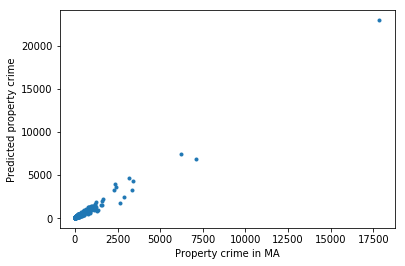

In [60]:
plt.plot(ma.property_crime, y_pred_ma, linestyle='none', marker='.')
plt.xlabel('Property crime in MA')
plt.ylabel('Predicted property crime')
plt.show()

In [61]:
data_all = pd.concat([ny, ca], join='inner')
data = data_all[revised3]
target = data_all['property_crime']

lm_ny_ca = LinearRegression()
model = lm_ny_ca.fit(data, target)

model.score(ma[revised3], ma.property_crime.values.reshape(-1,1))

0.7769620318436247

In [62]:
kfold = KFold(n_splits=10)
results = cross_val_score(lm_ny_ca, ma[revised3], ma['property_crime'], cv=kfold)
print(results)

[0.86293049 0.98006629 0.86363693 0.79637302 0.93894232 0.96995226
 0.83922756 0.92097864 0.91617804 0.98133621]


Whoa, not all folds behave great. How to figure out which data contributes?

In [63]:
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 90.696% (6.065%)
